In [355]:
import numpy as np
import math
from scipy.special import k0, k1, i0, i1
import matplotlib.pyplot as plt
from tqdm import tqdm


In [356]:
def del_y(simplex, k):
    ans = np.array([])
    
    for index in range(len(simplex)):
        ans = np.append(ans, del_yj(simplex, index, k)) #returns [del_Ys]
    return ans

def del_yj(simplex, index_j, k):
    
    if len(simplex) == 1:
        return 1
    
    ans = 0
    vj = simplex[index_j]
    simplex_i =  simplex.copy()
    simplex_i.pop(index_j)
    for i, j in enumerate(simplex_i):
        del_yi = del_yj(simplex_i, i, k)
        ans += del_yi * (j@(k-vj))
    return ans

In [357]:
def generate_all_simplexs_with_support(simplex, support):
    """Generate all possible simplexs from the given simplex with support."""
    if len(simplex) < 1:
        return [[support]]
    
    sub_simplexes = generate_all_simplexs(simplex)
    all_simplexs = [i + [support] for i in sub_simplexes]
    all_simplexs.append([support])
    return all_simplexs

def generate_all_simplexs(simplex):
    """Generate all possible simplexs from the given simplex."""
    if len(simplex) <= 1:
        return [simplex]
    
    simplexs = [simplex]
    for index in range(len(simplex)):
        next_simplex = simplex.copy()
        next_simplex.pop(index)
        sub_simplexs = generate_all_simplexs(next_simplex)
        simplexs.extend(sub_simplexs)
    return simplexs

In [358]:
def distance_subalgorithm(simplex, vj):
    """Sub-algorithm to compute the distance based on the current simplex."""
    all_simplexs = generate_all_simplexs_with_support(simplex[:-1], simplex[-1])
    backup_simplex = [[simplex[-1]]]
    backup_dist = [np.linalg.norm(simplex[-1])]
    backup_v = [simplex[-1]]

    for curr_simplex in all_simplexs:
        k = curr_simplex[0]
        del_simplex = del_y(curr_simplex, k)
        del_simplex_val = 0
        inside = True
        for i in del_simplex: #check if all del_simplex values are positive
            if i<0:
                inside = False
                break
            del_simplex_val += i

        if inside: #check del_simplex is positive
            
            v = np.zeros(curr_simplex[0].shape)
            for i in range(len(curr_simplex)):
                v += curr_simplex[i]*del_simplex[i] / del_simplex_val
            ik = curr_simplex@k
            dist = ik[i]*del_simplex[i]/ del_simplex_val
            del_yj = del_simplex@((curr_simplex@k)- curr_simplex@vj)
            if del_yj <= 0: #check del_j y_union_j is negative
                return curr_simplex, v, dist**0.5, True
            backup_simplex.append(curr_simplex)
            backup_v.append(v)
            backup_dist.append(dist**0.5)
            
    return backup_simplex[np.argmax(backup_dist)], backup_v[np.argmax(backup_dist)], np.max(backup_dist), False

In [361]:
## GJK Distance Algorithm Implementation By ME

EPSILPON = 0.001

def gjk_distance(shape1, shape2, simplex, distPrev = None, alg = True):#alg = True means it uses DS, False uses BP
    """Calculate the distance between two convex shapes using the GJK algorithm."""
    vj = shape2.center - shape1.center
    new_simplex, v, distB, alg = distance_subalgorithm(simplex, vj)
    support = support_vec(shape1, shape2, v)
    support_neg = support_vec(shape1, shape2, -v)

    
    if gk(-v, support_neg) <= EPSILPON:
        return distB, v, new_simplex, True

    if (not distPrev) or distB < distPrev:
        new_simplex.append(support)
        return gjk_distance(shape1, shape2, new_simplex, distB)
    
    if not alg: #backup procedure used and tolerance not satisfied
        return distB, v, new_simplex, alg #backup procedure used and tolerance not satisfied
    
    return gjk_distance(shape1, shape2, simplex, distPrev, False)
    

def gk(v, s):
    return np.linalg.norm(v)**2 + s@v

def support_vec(shapeA, shapeB, d):
    """
    Support point of Minkowski difference A - B
    """
    return shapeA.support(d) - shapeB.support(-d)

In [370]:
def normalize(v):
    n = np.linalg.norm(v)
    return v / n

class Sphere:
    def __init__(self, center, radius):
        self.center = np.array(center, dtype=float)
        self.radius = radius

    def support(self, d):
        d = normalize(d)
        return self.center + self.radius * d
    
class Box:
    def __init__(self, center, half_extents):
        self.center = np.array(center, dtype=float)
        self.half = np.array(half_extents, dtype=float)

    def support(self, d):
        return self.center + np.sign(d) * self.half
    
start_d = np.random.uniform(0,100,3)

def test_sphere_sphere_separated():
    s1 = Sphere(center=[202, 0, 0], radius=1.0)
    s2 = Sphere(center=[0, 0, 0], radius=200.0)
    simplex = [np.round(support_vec(s1, s2, start_d), 1)]

    dist = gjk_distance(s1, s2, simplex)
    expected = 0

    print("Sphere–Sphere separated")
    print("Expected:", expected)
    print("GJK:", dist)
    print()



if __name__ == "__main__":
    test_sphere_sphere_separated()

Sphere–Sphere separated
Expected: 0
GJK: (np.float64(390.35632067808757), array([378.1709334 ,  33.87902565,  90.64774595]), [array([378.1709334 ,  33.87902565,  90.64774595])], False)



In [ ]:
#helper functions
import numpy as np
import scipy as sp


def update_dimension(depth, num_vals):
    if depth == 1:
        return np.zeros(int(num_vals[0])+1)
    else:
        return np.array([update_dimension(depth - 1, num_vals[1:]) for i in range(int(num_vals[0])+1)])


def surrounding_max(current, domain, dim):
    next = current
    curr_max = -1
    for i in range(3**dim - 1):
        surrounding = current.copy()
        if surrounding[i] + 1 < len(domain[i]):
            surrounding[i] += 1
            val = get_val(surrounding, domain)
            if val > curr_max:
                curr_max = val
                next = surrounding
    return next

def surrounding_points(dim, layer):
    if layer == 1:
        return [i for i in range(-1,2)]
    
    current_layer = []
    for i in range(dim):
        for j in surrounding_points(dim, layer-1):
            current_layer.append(j.append(i))

def plot_solved_domain(point, domain, val):
    curr_dim = domain
    for i in range(len(point)- 1):
        curr_dim = curr_dim[point[i]]
    curr_dim[point[-1]] += val
    
def get_val(point, domain):
    curr_dim = domain
    for i in range(len(point)- 1):
        if point[i]<len(curr_dim):
            curr_dim = curr_dim[point[i]]
    return curr_dim[point[-1]]

def dist_to_boundary(x, boundary, obstacles):
    dist = np.abs(boundary.radius - np.linalg.norm(x-boundary.center))
    for obstacle in obstacles:
        dist = min(dist, np.abs(obstacle.radius - np.linalg.norm(x-obstacle.center)))
    return dist
'''def dist_to_boundary(x, boundary, obstacles):
    """Calculate the distance from point x to the given boundary."""
    simplex_b = x.support([1.0,0.0,0.0]) - boundary.support([1.0,0.0,0.0])
    simplex_o = x.support([1.0,0.0,0.0]) - obstacles.support([1.0,0.0,0.0])

    distB, v_b, simplex_b, reliable_b = gjk_distance(x, boundary, simplex_b)
    distO, v_o, simplex_o, reliable_o = gjk_distance(x, obstacles, simplex_o)
    return min(distB, distO)'''
 

def sample_sphere(DIM, r, center):
    """Sample a random point on the surface of a sphere."""
    vec = np.random.normal(0, 1, DIM)
    norm = np.sum(vec**2)**0.5
    vec = vec / norm  # Normalize to lie on the unit sphere
    return np.round(center + r * vec, decimals=1)

def sample_ball(DIM, r, center):
    """Sample a random point inside a ball."""
    sample = np.array(np.random.normal(0, 1, DIM + 2))
    norm = np.sum(sample**2)**0.5
    sample = sample / norm  # Normalize to lie on the unit sphere
    sample = sample[:DIM]  # Take only the first DIM dimensions
    return np.round(center + sample * r, decimals=1)

In [272]:
#math from chatgpt
def poisson_kernel(n, v, kappa, r):
    if kappa == 0:
        return 1
    return kappa ** v / ((2 * np.pi)**(n/2))*(r**(v+1)) /sp.special.iv(v, kappa*r)

def green_fn(n, v, kappa, r, y):
    y_norm = np.linalg.norm(y)
    return yukawa_kernel(kappa, n, y_norm) - sp.special.iv(v, kappa*y_norm)/sp.special.iv(v, kappa*r)*yukawa_kernel(kappa, n, r)
    
def yukawa_kernel(kappa, n, r):
    return 1/(2*np.pi)**(n/2 - 1) * sp.special.kn(n/2-1, kappa*r)

In [371]:
class GreensFnBall:
    def __init__(self, dim):
        self.dim = dim
        self.updateBall(np.zeros(dim), 0.0)

    def updateBall(self, c, R, rClamp=1e-4):
        self.c = c
        self.R = R
        self.rClamp = rClamp

    def evaluate(self, x=None, y=None):
        return 0.0

    def gradientNorm(self):
        return 0.0

    def gradient(self):
        return np.zeros(self.dim)

    def norm(self):
        return 0.0

    def poissonKernel(self):
        return 0.0

    def potential(self):
        return 0.0



In [372]:
class HarmonicGreensFnBall2D(GreensFnBall):
    def __init__(self):
        super().__init__(2)

    def evaluate(self, y):
        r = np.linalg.norm(self.c - y)
        return np.log(self.R / r) / (2.0 * np.pi)
        
    def poissonKernel(self):
        return 1.0 / (2.0 * np.pi)
    
    def direction_sampled_poisson_kernel(self):
        return 1.0


In [373]:
class HarmonicGreensFnBall3D(GreensFnBall):
    def __init__(self):
        super().__init__(3)

    def evaluate(self, y):
        r = np.linalg.norm(self.c - y)
        return (1.0/r - 1.0/self.R)/(4.0*np.pi)

    def poissonKernel(self):
        return 1.0 / (4.0 * np.pi)
    
    def direction_sampled_poisson_kernel(self):
        return 1.0


In [374]:
class YukawaGreensFnBall2D(GreensFnBall):
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.sqrt_lam = np.sqrt(lambda_)
        super().__init__(2)
        

    def updateBall(self, c, R,rClamp=1e-4):
        super().updateBall(c, R, rClamp)
        self.muR = self.R * self.sqrt_lam
        self.K0muR = k0(self.muR)
        self.I0muR = i0(self.muR)
        self.K1muR = k1(self.muR)
        self.I1muR = i1(self.muR)

    def evaluate(self, y):
        r = np.linalg.norm(self.c - y)
        mur = r * self.sqrt_lam
        K0mur = k0(mur)
        I0mur = i0(mur)

        return (K0mur - I0mur*self.K0muR/self.I0muR) / (2.0 * np.pi)

    def poissonKernel(self):
        return 1.0 / (2.0 * np.pi * self.I0muR)
    
    def direction_sampled_poisson_kernel(self):
        mur = self.R*self.sqrt_lam
        K1mur = k1(mur)
        I1mur = i1(mur)
        q = K1mur + I1mur*self.K0muR/self.I0muR

        return mur*q



In [375]:
class YukawaGreensFnBall3D(GreensFnBall):
    def __init__(self, lambda_):
        self.lambda_ = lambda_
        self.sqrt_lam = np.sqrt(lambda_)
        super().__init__(3)

    def updateBall(self, c, R, rClamp=1e-4):
        super().updateBall(c, R, rClamp)
        self.muR = R*self.sqrt_lam
        self.expmuR = np.exp(-self.muR)
        self.exp2muR = self.expmuR*self.expmuR
        self.coshmuR = (1.0 + self.exp2muR)/(2.0*self.expmuR)
        self.sinhmuR = (1.0 - self.exp2muR)/(2.0*self.expmuR)
        self.K32muR = self.expmuR*(1.0 + 1.0/self.muR)
        self.I32muR = self.coshmuR - self.sinhmuR/self.muR
    

    def evaluate(self, y):
        r = np.linalg.norm(self.c - y)
        mur = r*self.sqrt_lam
        expmur = np.exp(-mur)
        sinhmur = (1.0 - expmur*expmur)/(2.0*expmur)
        return (expmur - self.expmuR*sinhmur/self.sinhmuR)/(4.0*np.pi*r)


    def poissonKernel(self):
        return self.muR/(4.0*np.pi*self.sinhmuR)

    def direction_sampled_poisson_kernel(self):
        mur = self.R*self.sqrt_lam
        expmur = np.exp(-mur)
        exp2mur = expmur*expmur
        coshmur = (1.0 + exp2mur)/(2.0*expmur)
        sinhmur = (1.0 - exp2mur)/(2.0*expmur)
        K32mur = expmur*(1.0 + 1.0/mur)
        I32mur = coshmur - sinhmur/mur
        q = K32mur + I32mur*self.expmuR/self.sinhmuR
        return mur*q

In [376]:
class LaplaceEqn:
    def __init__(self, DIM, sigma, f, g, h = None):
        self.g = g
        self.f = f
        self.sigma = sigma
        self.h = h
        self.DIM = DIM

In [ ]:
def WoS(eqn, epsilon, boundary, obstacles, goal, start, n_walks):
    solved_domain = np.array([])
    max_boundary = boundary.max()
    min_boundary = boundary.min()
            
    range_boundary = (max_boundary - min_boundary)
    solved_domain = update_dimension(len(range_boundary), range_boundary)


    for walk in tqdm(range(n_walks), desc = 'Processing'):
        wos_walk(eqn, epsilon, boundary, obstacles, goal, sample_ball(eqn.DIM, boundary.radius, boundary.center), solved_domain)
    
    plt.imshow(solved_domain/n_walks, cmap='inferno', interpolation='nearest')
    plt.show()
    return solved_domain

def wos_walk(eqn, epsilon, boundary, obstacles, goal, start, solved_domain):
    distB = dist_to_boundary(start, boundary, obstacles)
    if distB < epsilon:
        return eqn.g
    
    v = np.round(sample_sphere(eqn.DIM, distB, start)).astype(int)
    z = sample_ball(eqn.DIM, distB, start)
    if eqn.sigma == 0:
        pde = YukawaGreensFnBall2D(eqn.sigma) #change based on whether sigma is 0
    else:
        pde = HarmonicGreensFnBall2D()

    pde.updateBall(start, distB)
    s = 0
    
    if dist_to_boundary(z, goal, [goal]) <=1:
        s = eqn.f*pde.evaluate(z)*np.pi*distB**2

    a = pde.direction_sampled_poisson_kernel()
    if a < np.random.uniform(0, 1):
        plot_solved_domain(np.round(start).astype(int), solved_domain, s)
        return s
    
    point = a*(wos_walk(eqn, epsilon, boundary, obstacles, goal, v, solved_domain) + s)
    plot_solved_domain(v, solved_domain, point)
    return point






Processing: 100%|██████████| 10000000/10000000 [26:51<00:00, 6205.29it/s]


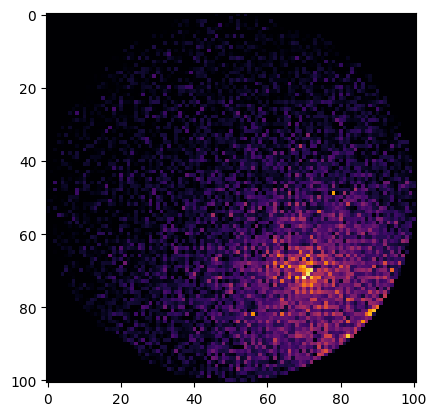

Sphere–Sphere separated


In [ ]:
def normalize(v):
    n = np.linalg.norm(v)
    if n < EPSILPON:
        return v
    return v / n

def support(shapeA, shapeB, d):
    """
    Support point of Minkowski difference A - B
    """
    return shapeA.support(d) - shapeB.support(-d)

class Sphere:
    def __init__(self, center, radius):
        self.center = np.array(center, dtype=float)
        self.radius = radius

    def support(self, d):
        d = normalize(d)
        return self.center + self.radius * d
    def max(self):
        return self.center + [self.radius, self.radius, ]
    def min(self):
        return self.center - [self.radius, self.radius]
    
def test_sphere():
    s1 = Sphere(center=[50, 50], radius=50.0)
    s2 =[Sphere(center=[50, 50], radius=5.0), Sphere(center=[50, 40], radius=5.0)]

    goal = Sphere(center=[70.0, 70], radius=0.0)

    eqn = LaplaceEqn(2, 1, 100, 0)

    domain = WoS(eqn, 1, s1, [], goal, np.array([20, 20]), 10000000) #WoS(eqn, epsilon, boundary, obstacles, goal, start, n_walks)
    
    print("Sphere–Sphere separated")

    # different from yours, see below
    return domain
    

hi = test_sphere()


In [ ]:
"""code that might make it more efficient"""

def FieldofView(start, distB, obstacles):
    """Calculate the field of view from point x given the distance to boundary and obstacles."""
    #not done
    if not obstacles:
        return 4 * np.pi  # Full sphere in 3D
    fov = 4 * np.pi
    for obstacle in obstacles:
        dist = np.linalg.norm(start - obstacle)
        if dist < distB:
            angle = np.arccos(dist / distB)
            fov -= 2 * np.pi * (1 - np.cos(angle))
    return fov

def DisttoClosestObstacle(start, obstacles):
    """Calculate the distance from point x to the closest obstacle."""
    #not done
    if not obstacles:
        return np.inf
    min_dist = np.inf
    for obstacle in obstacles:
        dist = np.linalg.norm(start - obstacle)
        if dist < min_dist:
            min_dist = dist
    return min_dist


def InstersectObstacle(x, v, obstacles):
    """Check if instersects obstacle."""
    ##use bounding volume hierarchy to check for ray intersecction
    #not done
    pointsInCube = CheckPointsInCube(x, v, obstacles)
    if pointsInCube:
        return SplitCube(x, v, pointsInCube)
    return pointsInCube
 


def SplitCube(cube_max, cube_min, points):
    if max(cube_max - cube_min) < 1 or points == []:
        return points
    
    smaller_cube_max = (cube_max + cube_min) / 2
    smallerCubeIntersect = SplitCube(smaller_cube_max, cube_min, CheckPointsInCube(smaller_cube_max, cube_min, points))
    largerCubeIntersect = SplitCube(cube_max, smaller_cube_max, CheckPointsInCube(cube_max, smaller_cube_max, points))
    return smallerCubeIntersect + largerCubeIntersect



def CheckPointsInCube(cube_max, cube_min, points):
    pointsInCube = []

    for point in points:
        inCube = True
        for i in point:
            for j in range(len(cube_max)):
                if i<cube_min[j] or i>cube_max[j]:
                    inCube = False
                    break
            if not inCube:
                break
        if inCube:
            pointsInCube.append(point)
    return pointsInCube

def SampleObstacle(obstacles):
    """Sample a random point on the surface of a random obstacle."""
    #not done
    if not obstacles:
        return None
    obstacle = obstacles[np.random.randint(len(obstacles))]
    return obstacle  # Assuming obstacle is a point; modify as needed for actual shapes

In [312]:
# python program to implement Quick Hull algorithm
# to find convex hull.

# Stores the result (points of convex hull)
hull = set()

# Returns the side of point p with respect to line
# joining points p1 and p2.
def findSide(p1, p2, p):
    val = (p[1] - p1[1]) * (p2[0] - p1[0]) - (p2[1] - p1[1]) * (p[0] - p1[0])

    if val > 0:
        return 1
    if val < 0:
        return -1
    return 0

# returns a value proportional to the distance
# between the point p and the line joining the
# points p1 and p2
def lineDist(p1, p2, p):
    return abs((p[1] - p1[1]) * (p2[0] - p1[0]) -
            (p2[1] - p1[1]) * (p[0] - p1[0]))

# End points of line L are p1 and p2. side can have value
# 1 or -1 specifying each of the parts made by the line L
def quickHull(a, n, p1, p2, side):

    ind = -1
    max_dist = 0

    # finding the point with maximum distance
    # from L and also on the specified side of L.
    for i in range(n):
        temp = lineDist(p1, p2, a[i])
        
        if (findSide(p1, p2, a[i]) == side) and (temp > max_dist):
            ind = i
            max_dist = temp

    # If no point is found, add the end points
    # of L to the convex hull.
    if ind == -1:
        hull.add("$".join(map(str, p1)))
        hull.add("$".join(map(str, p2)))
        return

    # Recur for the two parts divided by a[ind]
    quickHull(a, n, a[ind], p1, -findSide(a[ind], p1, p2))
    quickHull(a, n, a[ind], p2, -findSide(a[ind], p2, p1))

def printHull(a, n):
    # a[i].second -> y-coordinate of the ith point
    if (n < 3):
        print("Convex hull not possible")
        return

    # Finding the point with minimum and
    # maximum x-coordinate
    min_x = 0
    max_x = 0
    for i in range(1, n):
        if a[i][0] < a[min_x][0]:
            min_x = i
        if a[i][0] > a[max_x][0]:
            max_x = i

    # Recursively find convex hull points on
    # one side of line joining a[min_x] and
    # a[max_x]
    quickHull(a, n, a[min_x], a[max_x], 1)

    # Recursively find convex hull points on
    # other side of line joining a[min_x] and
    # a[max_x]
    quickHull(a, n, a[min_x], a[max_x], -1)

    print("The points in Convex Hull are:")
    
    for element in hull:
        x = element.split("$")
        print("(", x[0], ",", x[1], ") ", end = " ")

# Driver code
a = [[0, 3], [1, 1], [2, 2], [4, 4],
     [0, 0], [1, 2], [3, 1], [3, 3]]
n = len(a)
printHull(a, n)

# The code is contributed by Nidhi goel

The points in Convex Hull are:
( 3 , 1 )  ( 4 , 4 )  ( 0 , 0 )  ( 0 , 3 )  

In [ ]:
def surrounding_points(dim, layer):
    if layer == 1:
        for i in range(-1, 2):
            print(i)
        return [[i] for i in range(-1,2)]
    
    current_layer = np.array([])
    for i in range(dim):
        for j in surrounding_points(dim, layer-1):
            j.append(i)
            print(j)
            current_layer.append(j.)
    return current_layer

print(surrounding_points(2, 2))

-1
0
1
[-1, 0]


AttributeError: 'numpy.ndarray' object has no attribute 'append'